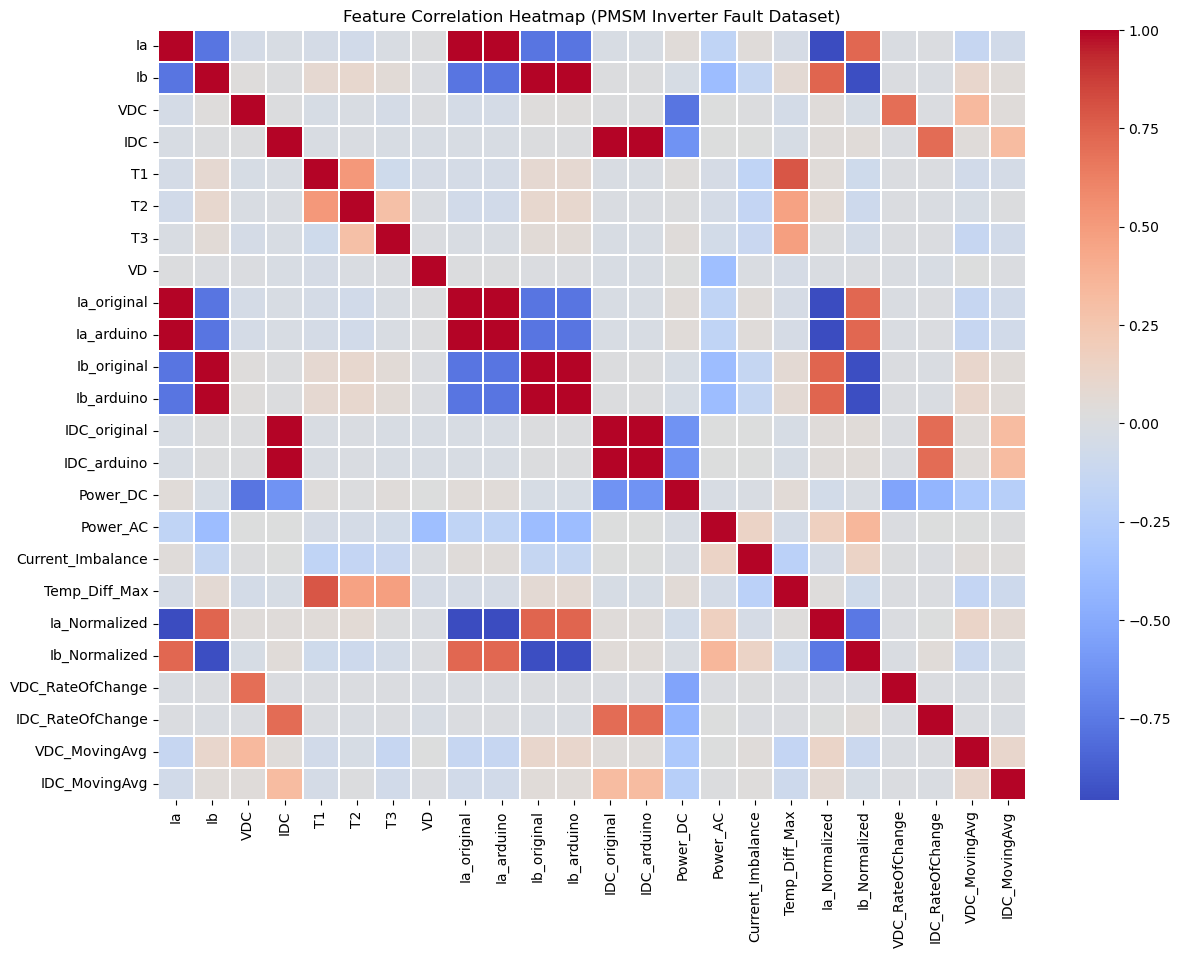

Features shape: (10848, 24)
Labels shape: (10848,)
Classes: ['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']
       Ia     Ib        VDC    IDC         T1         T2         T3  \
9   532.0  390.0 -17.106549  505.0  10.659462  11.401305  12.313061   
10  533.0  389.0 -17.106549  506.0  10.659462  11.566642  12.229922   
11  532.0  391.0 -17.106549  506.0  10.659462  11.483951  12.229922   
12  533.0  389.0 -26.881720  496.0  10.659462  11.815002  12.313061   
13  532.0  386.0 -17.106549  508.0  10.741722  11.401305  12.229922   

           VD FDD  Timestamp  ...   Power_DC    Power_AC  Current_Imbalance  \
9   -7.331378  F0        0.9  ...   8.861193   55.337243          -2.784314   
10 -12.218964  F0        1.0  ...   7.595308   92.228739          -2.823529   
11 -17.106549  F0        1.1  ...   7.595308  127.854350          -2.792079   
12  -2.443793  F0        1.2  ...  31.827957   18.445748          -2.823529   
13 -12.218964  F0        1.3  ...   5.063539   95.845552       

In [6]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

zip_path = "PMSM-inverter-fault-diagnosis-3.0.zip"
extract_dir = "PMSM_inverter_fault_data"

# Extract once
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Check structure
os.listdir(extract_dir)

csv_path = "PMSM_inverter_fault_data/PMSM-inverter-fault-diagnosis-3.0/processed_data/converted_dataset.csv"
df = pd.read_csv(csv_path)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


# Labels
y = df['FDD'].values   # fault class (F0..F8)

# Features (drop label + timestamp if not needed)
X = df.drop(columns=['FDD', 'Timestamp']).values

FeatureCorrelation = df.drop(columns=['FDD', 'Timestamp'])
corr = FeatureCorrelation.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", annot=False, linewidths=0.3)
plt.title("Feature Correlation Heatmap (PMSM Inverter Fault Dataset)")
plt.show()

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Classes:", sorted(set(y)))
print(df.head())
print("Number of features:", X.shape[1])
print("Feature names:", df.drop(columns=['FDD','Timestamp']).columns.tolist())


In [7]:
na_counts = df.drop(columns=['FDD','Timestamp']).isna().sum().sort_values(ascending=False)
print(na_counts[na_counts > 0])

# Are there infs?
import numpy as np
Xnum = df.drop(columns=['FDD','Timestamp']).apply(pd.to_numeric, errors='coerce')
print("Has +inf:", np.isposinf(Xnum.values).any(), "Has -inf:", np.isneginf(Xnum.values).any())

# Which rows have any NaN?
bad_rows = Xnum.index[Xnum.isna().any(axis=1)]
print("Rows with NaN:", len(bad_rows))

Series([], dtype: int64)
Has +inf: False Has -inf: False
Rows with NaN: 0


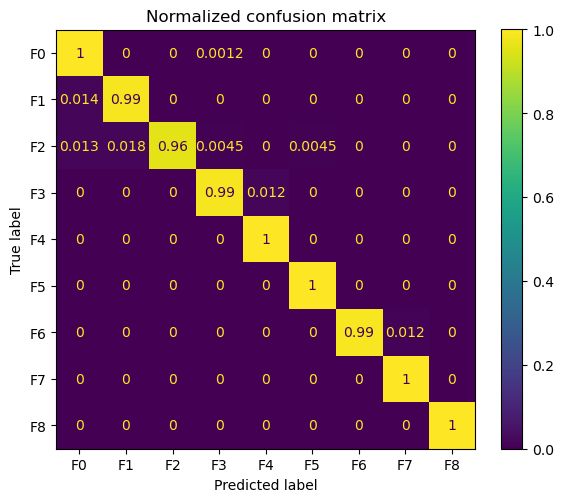

== Classification report (hold-out) ==
              precision    recall  f1-score   support

          F0       0.99      1.00      1.00       854
          F1       0.97      0.99      0.98       138
          F2       1.00      0.96      0.98       224
          F3       0.98      0.99      0.98        81
          F4       0.99      1.00      0.99        68
          F5       0.99      1.00      0.99        82
          F6       1.00      0.99      0.99       171
          F7       0.99      1.00      1.00       345
          F8       1.00      1.00      1.00       207

    accuracy                           0.99      2170
   macro avg       0.99      0.99      0.99      2170
weighted avg       0.99      0.99      0.99      2170

== Confusion matrix (rows=true, cols=pred) ==
[[853   0   0   1   0   0   0   0   0]
 [  2 136   0   0   0   0   0   0   0]
 [  3   4 215   1   0   1   0   0   0]
 [  0   0   0  80   1   0   0   0   0]
 [  0   0   0   0  68   0   0   0   0]
 [  0   0   0  

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y)  # integers 0..K-1

# 1) Hold-out split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 2) Train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    criterion="gini",         # try "entropy" or "log_loss" later
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",  # helpful if classes are imbalanced
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 3) Evaluate on the test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=np.arange(len(le.classes_)),   # your y_* are encoded ints 0..K-1
    display_labels=le.classes_,           # show "F0".."F8" on axes
    normalize='true',                     # per-row normalization
    ax=ax
)
ax.set_title("Normalized confusion matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.show()


print("== Classification report (hold-out) ==")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("== Confusion matrix (rows=true, cols=pred) ==")
print(confusion_matrix(y_test, y_pred))

try:
    print("Log loss:", log_loss(y_test, y_proba))
except Exception as e:
    print("Log loss not available:", e)

# 4) Cross-validation (stratified K-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "neg_log_loss": "neg_log_loss"
}

cv_results = cross_validate(
    rf, X, y_enc, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("\n== 5-fold CV results ==")
for k, v in cv_results.items():
    if k.startswith("test_"):
        scores = v
        metric = k.replace("test_", "")
        mean, std = scores.mean(), scores.std()
        # If neg_log_loss, convert sign back
        if metric == "neg_log_loss":
            print(f"log_loss: {(-scores).mean():.4f} ± {(-scores).std():.4f}")
        else:
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# 5) Optional: show top features
importances = rf.feature_importances_
feat_names = df.drop(columns=['FDD','Timestamp']).columns
top_idx = np.argsort(importances)[::-1][:20]
print("\n== Top features ==")
for i in top_idx:
    print(f"{feat_names[i]:30s} {importances[i]:.4f}")
    
    